In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import jax

from pulsedjax.simulate_trace import MakeTrace, apply_noise, GaussianAmplitude, PolynomialPhase, MultiPulse, RandomPhase

/home/tillstehling/miniconda3/lib/python3.11/site-packages/refractiveindex/refractiveindex.py:300: RuntimeWarning: invalid value encountered in sqrt
  n = np.sqrt(nsq)


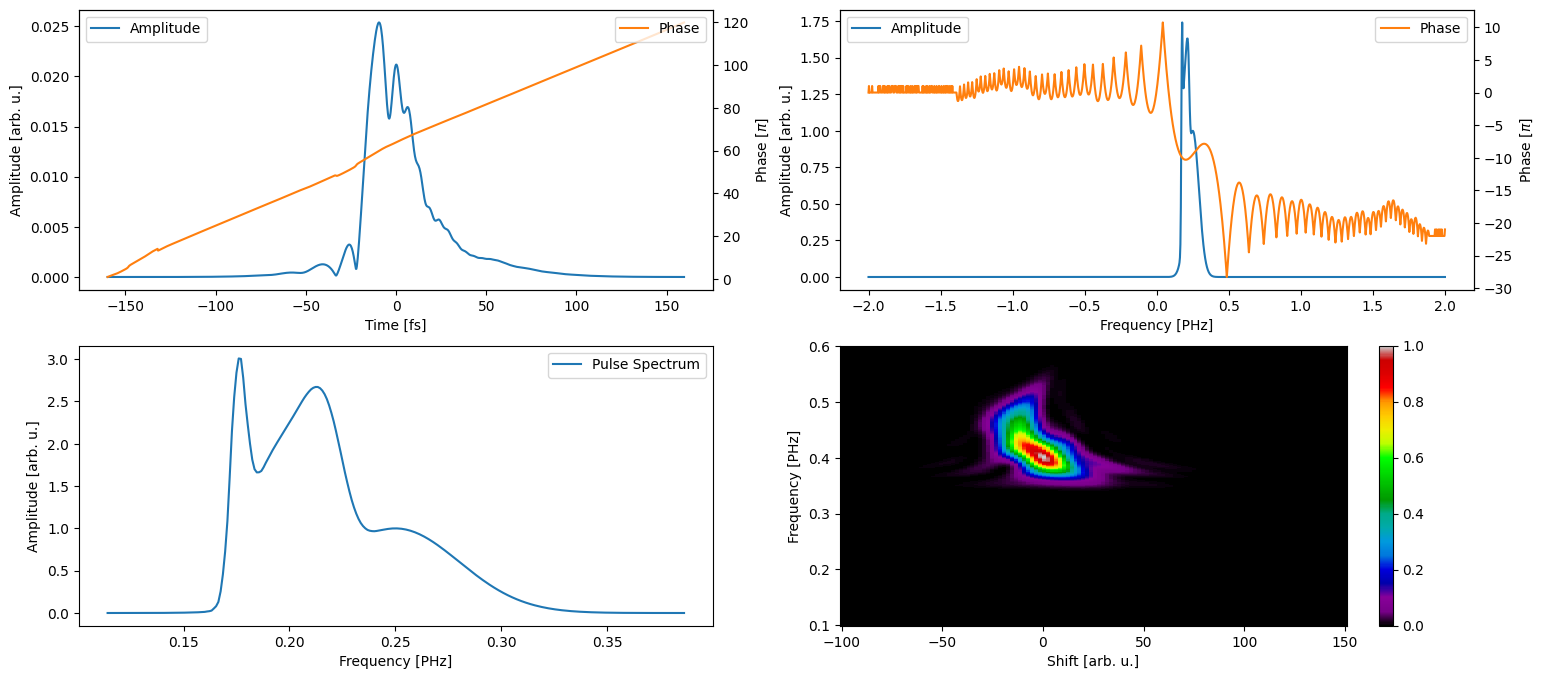

In [2]:
from pulsedjax.simulate_trace import MakeTrace
from pulsedjax.simulate_trace import GaussianAmplitude, PolynomialPhase
import jax.numpy as jnp

amp0 = GaussianAmplitude((1,1,1), (0.175,0.2,0.25), (0.01,0.05,0.1), (1,2,1))
phase0 = PolynomialPhase(None, (0,10,20,-30))
phase1 = PolynomialPhase(None, (0,60,20,-30))

mp = MakeTrace(N=128*10, f_max=2)
time, frequency, pulse_t, pulse_f = mp.generate_pulse((amp0,phase0))

_, frequency_gate, _, pulse_f_gate = mp.generate_pulse((amp0,phase1))


# import refractiveindex
# parameters = refractiveindex.RefractiveIndexMaterial(shelf="main", book="SiO2", page="Malitson")
# z_arr = jnp.linspace(-5,5,128) 
# z_arr, frequency_trace, trace, spectra = mp.generate_chirpscan(time, frequency, pulse_t, pulse_f, "shg", 
#                                                                z_arr, phase_type="material", parameters=parameters,
#                                                                frequency_range=(0.1,0.65), N=128)


from pulsedjax import get_spectral_filter

spectral_filter = get_spectral_filter("lorentzian", frequency, (1,0.2,0.05,1), material_thickness=2)


delay = jnp.linspace(-100,150,128) 
delay, frequency_trace, trace, spectra = mp.generate_tdp(time, frequency, pulse_t, pulse_f, "shg", delay, spectral_filter,
                                                         frequency_range=(0.1,0.6), N=128*2,
                                                         cross_correlation=False, gate=(frequency_gate, pulse_f_gate))


In [3]:
from pulsedjax.utilities import do_interpolation_1d
spectral_filter = do_interpolation_1d(frequency_trace, frequency, spectral_filter)

In [4]:
from pulsedjax.tdp import Evosax
from evosax.algorithms import DifferentialEvolution

copra = Evosax(delay, frequency_trace, trace, "shg", spectral_filter, solver=DifferentialEvolution)

population = copra.create_initial_population(4, "gaussian", "sigmoidal")


# final_result = copra.run(population, 5)
# copra.plot_results(final_result)

In [7]:
import pulsedjax.real_fields
import pulsedjax.frog
import pulsedjax.tdp
import pulsedjax.vampire
import pulsedjax.twodsi
import pulsedjax.chirp_scan

from pulsedjax.utilities import MyNamespace
import jax.numpy as jnp



class pulsedjax_testing:
    def __init__(self, method, algorithm, real_fields=False):
        self.method = method
        self.algorithm = algorithm
        self.real_fields = real_fields

        if real_fields==True:
            self.package = getattr(pulsedjax.real_fields, method)
        else:
            self.package = getattr(pulsedjax, method)
        
        if method!="chirp_scan" and method!="twodsi" and self.real_fields==False:
            self.CPCGPA = getattr(self.package, "CPCGPA")
            self.LSGPA = getattr(self.package, "LSGPA")
        else:
            self.CPCGPA = None
            self.LSGPA = None

        self.GP = getattr(self.package, "GeneralizedProjection")
        self.PIE = getattr(self.package, "PtychographicIterativeEngine") 
        self.COPRA = getattr(self.package, "COPRA")

        self.DE = getattr(self.package, "DifferentialEvolution")
        self.Evosax = getattr(self.package, "Evosax")
        self.LSF = getattr(self.package, "LSF")
        self.AutoDiff = getattr(self.package, "AutoDiff")

        if any([algorithm == i for i in (pulsedjax.frog.Vanilla, self.LSGPA, self.CPCGPA, self.PIE)]) and method=="frog" or method=="tdp":
            self.method_isnt_for_interferometric=True
        else:
            self.method_isnt_for_interferometric=False


        if algorithm == self.CPCGPA:
            self.method_isnt_for_sd=True
        else:
            self.method_isnt_for_sd=False

        if algorithm == pulsedjax.frog.Vanilla or algorithm == pulsedjax.frog.LSGPA:
            self.isnt_for_doubleblind=True
        else:
            self.isnt_for_doubleblind=False

        

    
    def make_method_kwargs(self, i, frequency, method):
        """ Creates a dict with method parameters, given hardcoded lists of options. """

        from pulsedjax import get_spectral_filter
        spectral_filter1 = get_spectral_filter("gaussian", frequency, (1, 0.25, 0.01, 1))
        spectral_filter2 = get_spectral_filter("lorentzian", frequency, (1, 0.26, 0.01, 1))

        material_thickness = 1
        tau_pulse_anc1 = 0
        tau_interferometer = 5

        phase_type = "material"
        import refractiveindex
        chirp_parameters = refractiveindex.RefractiveIndexMaterial(shelf="main", book="SiO2", page="Malitson")

        cross_correlation = [False, True, "doubleblind", False, "doubleblind"]
        interferometric = [True, False, True, False, False]
        nonlinear_method = ["shg", "thg", "sd", "5hg", "pg"]

        if self.method_isnt_for_interferometric==True:
            interferometric = [False, False, False, False, False]

        if self.method_isnt_for_sd==True:
            nonlinear_method = ["shg", "thg", "pg", "5hg", "pg"]

        if self.isnt_for_doubleblind==True:
            cross_correlation = [False, True, False, False, True]


        if method=="frog":
            method_kwargs = dict(cross_correlation = cross_correlation[i],
                                interferometric = interferometric[i],
                                nonlinear_method = nonlinear_method[i])
        elif method=="tdp":
            method_kwargs = dict(spectral_filter = spectral_filter1,
                                cross_correlation = cross_correlation[i],
                                interferometric = interferometric[i],
                                nonlinear_method = nonlinear_method[i])
        elif method=="twodsi":
            method_kwargs = dict(spectral_filter1 = spectral_filter1,
                                spectral_filter2 = spectral_filter2,
                                tau_pulse_anc1 = tau_pulse_anc1,
                                material_thickness = material_thickness,
                                cross_correlation = cross_correlation[i],
                                nonlinear_method = nonlinear_method[i])
        elif method=="vampire":
            method_kwargs = dict(material_thickness = material_thickness,
                                tau_interferometer = tau_interferometer,
                                cross_correlation = cross_correlation[i],
                                nonlinear_method = nonlinear_method[i])
        elif method=="chirp_scan":
            method_kwargs = dict(phase_type = phase_type,
                                chirp_parameters = chirp_parameters,
                                nonlinear_method = nonlinear_method[i])
        else:
            raise ValueError
        
        return method_kwargs



    def make_run_kwargs_classical(self, i, algorithm):
        """ Creates a dict with algorithm parameters for classical algorithms, given hardcoded lists of options. """
        options_gp_no_steps = [2, 2, 2, 2, 2]

        options_pie_method = [None, None, "PIE", "ePIE", "rPIE"]

        options_pcgpa_svd = [True, False, False, False, True]
        options_pcgpa_constraints = [True, True, False, False, False]
        options_pcgpa_antialias = [True, False, True, False, True]

        options_linesearch_method = [False, False, "backtracking", "zoom", False]
        options_delta_gamma_linesearch = [0.5, 0.5, 0.5, 1.5, 0.5] # delta_gamma
        options_ncg = ["fletcher_reeves", "polak_ribiere", "hestenes_stiefel", "dai_yuan", False]
        options_global_newton = [False, "lbfgs", "diagonal", "full", "lbfgs"]
        options_global_newton_pie = [False, "lbfgs", "diagonal", False, "lbfgs"] # global newton for pie
        options_s_prime_method = ["projection", "iteration", "iteration", "iteration", "iteration"]
        options_r_error = ["intensity", "intensity", "amplitude", "amplitude", "intensity"]
        options_r_error_newton = [False, True, True, False, False]

        if algorithm == self.PIE:
            options_newton = options_global_newton_pie
        else:
            options_newton = options_global_newton

        run_kwargs = dict(linesearch = options_linesearch_method[i],
                        delta_gamma = options_delta_gamma_linesearch[i],
                        conjugate_gradients = options_ncg[i],
                        global_newton = options_newton[i],
                        r_global_method = options_s_prime_method[i],
                        r_gradient = options_r_error[i],
                        r_newton = options_r_error_newton[i])
        
        if algorithm == self.GP:
            run_kwargs_add = dict(no_steps_descent = options_gp_no_steps[i])
        elif algorithm == self.PIE:
            run_kwargs_add = dict(pie_method = options_pie_method[i])
        elif algorithm == self.CPCGPA:
            run_kwargs_add = dict(svd = options_pcgpa_svd[i],
                                constraints = options_pcgpa_constraints[i],
                                antialias = options_pcgpa_antialias[i])
        else:
            run_kwargs_add = {}
        
        run_kwargs = {**run_kwargs, **run_kwargs_add}
        return run_kwargs


    def make_run_kwargs_general(self, i, algorithm):
        """ Creates a dict with algorithm parameters for general algorithms, given hardcoded lists of options. """
        if algorithm == self.DE:
            options_de_strategy = ["best1_exp", "best2_bin", "rand1_smooth", "currenttobest1_bin", "randtobest2_exp"]
            options_de_selection = ["greedy", "global", "global", "greedy", "greedy"]
            run_kwargs = dict(strategy = options_de_strategy[i],
                            selection_mechanism = options_de_selection[i])

        elif algorithm == self.Evosax:
            from evosax.algorithms import DifferentialEvolution, DiffusionEvolution, CMA_ES, Open_ES, ESMC
            options_evo = [DifferentialEvolution, DiffusionEvolution, CMA_ES, Open_ES, ESMC]
            run_kwargs = dict(solver = options_evo[i])

        elif algorithm == self.LSF:
            options_lsf = ["random", "random", "continuous", "continuous", "random"]
            run_kwargs = dict(random_direction_mode = options_lsf[i])

        elif algorithm == self.AutoDiff:
            from optax import adam, lbfgs
            from optimistix import LBFGS, LevenbergMarquardt, GradientDescent
            options_ad_solver = [adam(learning_rate=0.1), lbfgs(learning_rate=0.1), LBFGS(1,1), LevenbergMarquardt(1,1), GradientDescent(0.1,1,1)]
            options_ad_alternating = [True, False, False, True, True]
            run_kwargs = dict(solver = options_ad_solver[i],
                            alternating_optimization = options_ad_alternating[i])

        else:
            raise ValueError
        
        return run_kwargs



    def make_population_kwargs_classical(self, i):
        guess_options = ["random", "random_phase", "constant", "constant_phase", "random"]
        return dict(guess_type = guess_options[i])
    
    def make_population_kwargs_general(self, i):
        amp_guess = ["gaussian", "lorentzian", "bsplines_5", "continuous", "random"]
        phase_guess = ["polynomial", "sinusoidal", "sigmoidal", "bsplines_5", "constant"]
        no_amp = [5,5,15,5,5]
        no_phase = no_amp
        return dict(amp_type=amp_guess[0], phase_type=phase_guess[0], no_funcs_amp=no_amp[0], no_funcs_phase=no_phase[i])


    def make_run_and_population_kwargs(self, i, algorithm):
        if any([algorithm == i for i in (self.DE, self.Evosax, self.LSF, self.AutoDiff)]):
            run_kwargs = self.make_run_kwargs_general(i, algorithm)
            population_kwargs = self.make_population_kwargs_general(i)
        else:
            run_kwargs = self.make_run_kwargs_classical(i, algorithm)
            population_kwargs = self.make_population_kwargs_classical(i)

        return run_kwargs, population_kwargs


    def make_run_args(self, algorithm):
        if any([algorithm == i for i in (self.PIE, self.COPRA)]):    
            run_args = (3, 3)
        else:
            run_args = (3, )
        return run_args
    


    def make_m_parameters(self, i, method):
        (theta, frequency, trace, spectra), method_kwargs = self.get_trace(i, method)
        m_parameters = MyNamespace(theta=theta, frequency=frequency, trace=trace, spectra=spectra, method_kwargs=method_kwargs)
        return m_parameters



    def make_a_parameters(self, i, algorithm):
        run_kwargs, population_kwargs = self.make_run_and_population_kwargs(i, algorithm)
        run_args = self.make_run_args(algorithm)

        spectra = [False, True, True, False, False]
        if any([algorithm == i for i in (self.DE, self.Evosax, self.LSF, self.AutoDiff)]):
            momentum = [False, False, False, False, False]
        else:
            momentum = [True, True, False, False, False]

        a_parameters = MyNamespace(population_kwargs=population_kwargs, run_kwargs=run_kwargs, run_args=run_args, use_spectra=spectra[i], use_momentum=momentum[i])
        return a_parameters
    


    



    def interpolate_spectral_filter_onto_new_frequency(self, frequency, frequency_trace, method, method_kwargs):
        from pulsedjax.utilities import do_interpolation_1d

        if method=="tdp":
            spectral_filter = do_interpolation_1d(frequency_trace, frequency, method_kwargs["spectral_filter"])
            method_kwargs["spectral_filter"] = spectral_filter
        elif method=="twodsi":
            spectral_filter1 = do_interpolation_1d(frequency_trace, frequency, method_kwargs["spectral_filter1"])
            spectral_filter2 = do_interpolation_1d(frequency_trace, frequency, method_kwargs["spectral_filter2"])
            method_kwargs["spectral_filter1"] = spectral_filter1
            method_kwargs["spectral_filter2"] = spectral_filter2
        else:
            pass

        return method_kwargs





    def get_pulse(self):
        from pulsedjax.simulate_trace import MakeTrace, GaussianAmplitude, PolynomialPhase

        amp = GaussianAmplitude(1, 0.25, 0.1, 1)
        phase = PolynomialPhase(None, (0,0))

        pm = MakeTrace(N=128*6, f_max=1)
        time, frequency, pulse_t, pulse_f = pm.generate_pulse((amp, phase))

        return pm, (time, frequency, pulse_t, pulse_f)



    def get_trace(self, i, method):
        pm, (time, frequency, pulse_t, pulse_f) = self.get_pulse()

        method_kwargs = self.make_method_kwargs(i, frequency, method)


        generate_trace = dict(frog = pm.generate_frog,
                            tdp = pm.generate_tdp,
                            chirp_scan = pm.generate_chirpscan,
                            twodsi = pm.generate_2dsi,
                            vampire = pm.generate_vampire)



        theta = jnp.linspace(-10, 10, 128)

        method_kwargs_temp = method_kwargs.copy()
        nonlinear_method = method_kwargs_temp.pop("nonlinear_method")
        theta, frequency_trace, trace, spectra = generate_trace[method](time, frequency, pulse_t, pulse_f, nonlinear_method, theta, 
                                                                        gate=(frequency, pulse_f), real_fields=self.real_fields,
                                                                        N=128, plot_stuff=False, **method_kwargs_temp)
        

        method_kwargs = self.interpolate_spectral_filter_onto_new_frequency(frequency, frequency_trace, method, method_kwargs)
        self.gen_data = (theta, frequency_trace, trace, spectra)
        return (theta, frequency_trace, trace, spectra), method_kwargs




    def run_algorithm(self, algorithm, a_parameters, m_parameters):
        theta, frequency, trace = m_parameters.theta, m_parameters.frequency, m_parameters.trace
        method_kwargs = m_parameters.method_kwargs

        population_kwargs = a_parameters.population_kwargs
        run_kwargs = a_parameters.run_kwargs
        run_args = a_parameters.run_args

        population_size = 6

        myalgorithm = algorithm(theta, frequency, trace, **method_kwargs)
        population = myalgorithm.create_initial_population(population_size, **population_kwargs)

        if myalgorithm.cross_correlation==True:
            gate = myalgorithm.get_gate_pulse(m_parameters.spectra.pulse[0], m_parameters.spectra.pulse[1])

        if a_parameters.use_spectra==True:
            frequency_spectrum_pulse, spectrum_pulse = m_parameters.spectra.pulse[0], m_parameters.spectra.pulse[1]
            myalgorithm.use_measured_spectrum(frequency_spectrum_pulse, spectrum_pulse, "pulse")

            if myalgorithm.cross_correlation=="doubleblind":
                frequency_spectrum_gate, spectrum_gate = m_parameters.spectra.gate[0], m_parameters.spectra.gate[1]
                myalgorithm.use_measured_spectrum(frequency_spectrum_gate, spectrum_gate, "gate")

        if a_parameters.use_momentum==True:
            myalgorithm.momentum(population_size, 0.5)

        run_args = (population, ) + run_args
        final_result = myalgorithm.run(*run_args, **run_kwargs)




def run_test(i, method, algorithm, real_fields=False):
    test = pulsedjax_testing(method, algorithm, real_fields)
    m_parameters = test.make_m_parameters(i, method)
    a_parameters = test.make_a_parameters(i, algorithm)
    test.run_algorithm(algorithm, a_parameters, m_parameters)
    return test


In [8]:
from pulsedjax.frog import (Vanilla, LSGPA, CPCGPA, GeneralizedProjection, PtychographicIterativeEngine, 
                            COPRA, DifferentialEvolution, Evosax, LSF, AutoDiff)


algorithms_list = [Vanilla, LSGPA, CPCGPA, GeneralizedProjection, PtychographicIterativeEngine, COPRA, 
                   DifferentialEvolution, Evosax, LSF, AutoDiff]

def test_frog(algorithm):
    for i in range(5):
        test = run_test(i, "frog", algorithm, real_fields=False)


In [ ]:
# some isse with evosax

In [3]:
t = run_test(0, "frog", Evosax, real_fields=False)

In [9]:
test_frog(Evosax)

Doubleblind Retrieval has uniqueness issues. You should provide spectra for pulse and gate-pulse.
Doubleblind Retrieval has uniqueness issues. You should provide spectra for pulse and gate-pulse.


In [4]:
for algorithm in algorithms_list[-2:]:
    test_frog(algorithm)

LSF is only implemented for amp_type=discrete, phase_type=discrete and converts the populations accordingly.
LSF is only implemented for amp_type=discrete, phase_type=discrete and converts the populations accordingly.
Doubleblind Retrieval has uniqueness issues. You should provide spectra for pulse and gate-pulse.
LSF is only implemented for amp_type=discrete, phase_type=discrete and converts the populations accordingly.
LSF is only implemented for amp_type=discrete, phase_type=discrete and converts the populations accordingly.
Doubleblind Retrieval has uniqueness issues. You should provide spectra for pulse and gate-pulse.
LSF is only implemented for amp_type=discrete, phase_type=discrete and converts the populations accordingly.
Doubleblind Retrieval has uniqueness issues. You should provide spectra for pulse and gate-pulse.
Doubleblind Retrieval has uniqueness issues. You should provide spectra for pulse and gate-pulse.
